In [1]:
import sys
sys.path.append('..')

import os
import psutil
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np
np.random.seed(0)

In [2]:
import matplotlib.pyplot as plt
from pylab import *
from keras.models import Sequential
from keras import optimizers
from keras.models import load_model
from keras.optimizers import Adam, SGD
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout, Convolution2D, Dense
from keras.models import Model
from keras.datasets import cifar10

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform,he_uniform

from keras.preprocessing.image import ImageDataGenerator
from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from custom_lib.triplet_utils import buildDataSet, build_model
from custom_lib.triplet_utils import get_batch_hard, compute_probs
from custom_lib.triplet_utils import add_top, remove_top

from art.classifiers import KerasClassifier
from art.attacks.projected_gradient_descent import ProjectedGradientDescent
from art.attacks.iterative_method import BasicIterativeMethod
from art.defences.adversarial_trainer import AdversarialTrainer
from art.attacks.fast_gradient import FastGradientMethod

from custom_lib.build_resnet import resnet_v1, resnet_emb

Using TensorFlow backend.


In [12]:
from custom_lib.triplet_loss import batch_hard_triplet_loss
from custom_lib.triplet_loss import batch_all_triplet_loss
from custom_lib.triplet_loss import mixed_loss
from tensorflow.contrib.losses import metric_learning

def keras_batch_hard_triplet_loss(labels, y_pred):
    labels = K.flatten(labels)
    return batch_hard_triplet_loss(labels, y_pred, margin = 0.05)

def keras_batch_all_triplet_loss(labels, y_pred):
    labels = K.flatten(labels)
    return batch_all_triplet_loss(labels, y_pred, margin = 0.7)

def keras_semi_hard_loss(labels, y_pred):
    labels = K.flatten(labels)
    return metric_learning.triplet_semihard_loss(labels, y_pred, margin=0.5)

def keras_mixed_loss(labels, y_pred):
    labels = K.flatten(labels)
    return mixed_loss(labels, y_pred, margin = 0.7, ratio=0.2)

In [4]:
def restrict_cpu():
    p = psutil.Process()

    for i in p.threads():
        temp = psutil.Process(i.id)

        temp.cpu_affinity([i for i in range(10)])

In [5]:
from keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train / 255.
x_test = x_test / 255.

val_train = to_categorical(y_train, 10)
val_test = to_categorical(y_test, 10)

In [7]:
import itertools
import random

learning_rate = 5e-6
batch_size=64
epochs=10

nb_classes = 10
img_rows, img_cols = 32, 32
input_shape = (img_rows, img_cols, 3)
in_shape = input_shape

'''
dataset_train, dataset_test, x_train_origin, y_train_origin, x_test_origin, y_test_origin = buildDataSet(cifar=True)

del x_train_origin, y_train_origin, x_test_origin, y_test_origin

dataset_train = np.array(list(itertools.chain.from_iterable(dataset_train)))
dataset_test = np.array(list(itertools.chain.from_iterable(dataset_test)))

dataset_y = np.array([i // 5000 for i in range(50000)])
dataset_y = np.expand_dims(dataset_y, axis=1)

dataset_y_c = to_categorical(dataset_y, 10)
'''
None

In [8]:
'''
temp = resnet_v1(input_shape)

temp.load_weights("saved_models/resnet.h5")
temp.compile(optimizer=Adam(lr=5e-4), loss='categorical_crossentropy', metrics=["accuracy"])

base_model = resnet_emb(input_shape)

for i, layer in enumerate(base_model.layers):
    layer.set_weights(temp.layers[i].get_weights())
    
base_model.save_weights("old_base.h5")
'''
None

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


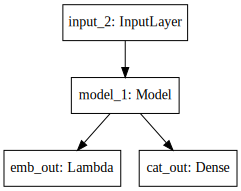

In [9]:
# -------------------- Base Model --------------------------

base_model = resnet_emb(input_shape)
base_model.load_weights("saved_models/old_base.h5")

base_in = Input(shape=in_shape)
base_out = base_model(base_in)

# -------------------- Emb Model ---------------------------

emb_branch = Lambda(lambda  t: K.l2_normalize(t,axis=-1), name="emb_out")(base_out)
                                                  
# -------------------- Categorical Model -------------------

cat_branch = Dense(10, activation='softmax', name="cat_out")(base_out)

# -------------------- Compile -----------------------------

model = Model(inputs=base_in, 
              outputs=[emb_branch, cat_branch], 
              name="fullnet")

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [13]:
losses = {
    "emb_out": keras_batch_hard_triplet_loss,
    "cat_out": "categorical_crossentropy",
}

lossWeights = {"emb_out": 2, "cat_out": 0.3}

model.compile(optimizer=Adam(lr=5e-4), loss=losses, loss_weights=lossWeights, metrics=["accuracy"])

In [14]:
b_in = Input(shape=in_shape)
b_out = model(b_in)[1]

adv_model = Model(inputs=b_in, outputs=b_out)
adv_model.compile(loss="categorical_crossentropy", optimizer=Adam(5e-4), metrics=["accuracy"])

In [15]:
model.fit(x_train, [y_train, val_train],
          validation_data=(x_test, [y_test, val_test]),
          epochs=1, 
          batch_size=32,
          verbose=1)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 50000 samples, validate on 10000 samples
Epoch 1/1
50000/50000 [==============================] - 81s 2ms/step - loss: 0.4496 - emb_out_loss: 0.1127 - cat_out_loss: 0.3702 - emb_out_acc: 0.0000e+00 - cat_out_acc: 0.8866 - val_loss: 0.4021 - val_emb_out_loss: 0.0843 - val_cat_out_loss: 0.4064 - val_emb_out_acc: 0.0000e+00 - val_cat_out_acc: 0.8670


In [16]:
art_model = KerasClassifier(clip_values=(0, 1.), model=adv_model, use_logits=False)
attack = ProjectedGradientDescent(art_model, norm=2, eps=5, random_eps=True, eps_step=0.8, max_iter=6, batch_size=16)

adv_test = attack.generate(x_test[:10])

restrict_cpu()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [13]:
eval_loss = adv_model.evaluate(x_test, val_test, verbose=0)

print("Base images:")
for i, name in enumerate(adv_model.metrics_names):
    print(name, eval_loss[i])
    
losses = []
accs = []


for i in range(0, 8000, 32):
    adv_test = attack.generate(x_test[i:i+32])
    eval_loss = adv_model.evaluate(adv_test, val_test[i:i+32], verbose=0)
    losses.append(eval_loss[0])
    accs.append(eval_loss[1])

print("\nAdv images:")
print('loss', np.mean(losses))
print('acc', np.mean(accs))

Base images:
loss 0.47745966601371764
acc 0.8793

Adv images:
loss 13.410612855196
acc 0.092625


In [17]:
def batch_generator(X, Y, VAL, batch_size = 64):
    
    indices = np.arange(len(X)) 
    
    #class_idx = random.randint(0, 9)
    #indices = list(range(5000 * class_idx, (5000 * (class_idx + 1))))
    
    batch=[]
    while True:
            # it might be a good idea to shuffle your data before each epoch
            np.random.shuffle(indices) 
            for i in indices:
                batch.append(i)
                if len(batch)==batch_size:
                    adv_x = X[batch]
                    adv_x[:128] = attack.generate(adv_x[:128])
                    yield adv_x, [Y[batch], VAL[batch]]
                    batch=[]

train_generator = batch_generator(x_train, y_train, val_train, batch_size = 256)
#train_generator = batch_generator(dataset_train, dataset_y, dataset_y_c, batch_size = 256)

In [28]:
asdf = {key:[] for key in model.metrics_names}

model.metrics_names

['loss', 'emb_out_loss', 'cat_out_loss', 'emb_out_acc', 'cat_out_acc']

In [42]:
#K.set_value(model.optimizer.lr, 5e-4)

In [ ]:
# Hyper parameters
evaluate_every = 125 # interval for evaluating on one-shot tasks
n_iter = 16_000 # No. of training iterations
n_val = 250 # how many one-shot tasks to validate on
n_iteration=0

loss_list = []
total_loss = []

emb_vals = []
cat_vals = []
acc_vals = []

print("Starting training process!")
print("-------------------------------------")

t_start = time.time()

for i in range(1, n_iter+1):
    
    batch = train_generator.__next__()
    
    loss = model.train_on_batch(batch[0], batch[1])
    
    emb_vals.append(loss[1])
    cat_vals.append(loss[2])
    acc_vals.append(loss[4])
    
    n_iteration += 1
    
    if i % 4000 == 0:
        K.set_value(model.optimizer.lr, K.get_value(model.optimizer.lr)/2.0)
    
    if i % evaluate_every == 0:
        ploss = (np.mean(emb_vals), np.mean(cat_vals), np.mean(acc_vals))
        loss_list.append(ploss)
        emb_vals = []
        cat_vals = []
        acc_vals = []
        print("\n ------------- \n")
        print("[{3}] Time for {0} iterations: {1:.1f} mins, Train Loss: {2}".format(i, (time.time()-t_start)/60.0,ploss,n_iteration))

Starting training process!
-------------------------------------

 ------------- 

[125] Time for 125 iterations: 2.0 mins, Train Loss: (0.11673343, 1.9577178, 0.5165312)

 ------------- 

[250] Time for 250 iterations: 4.0 mins, Train Loss: (0.098639384, 1.5557694, 0.5215625)

 ------------- 

[375] Time for 375 iterations: 5.9 mins, Train Loss: (0.09473609, 1.5482008, 0.51575)

 ------------- 

[500] Time for 500 iterations: 7.9 mins, Train Loss: (0.09134113, 1.5434161, 0.522375)

 ------------- 

[625] Time for 625 iterations: 9.9 mins, Train Loss: (0.08906166, 1.5632133, 0.51034373)

 ------------- 

[750] Time for 750 iterations: 11.9 mins, Train Loss: (0.08761311, 1.462558, 0.5398125)

 ------------- 

[875] Time for 875 iterations: 13.8 mins, Train Loss: (0.08660543, 1.4436023, 0.544125)

 ------------- 

[1000] Time for 1000 iterations: 15.8 mins, Train Loss: (0.08473483, 1.4050677, 0.5605625)

 ------------- 

[1125] Time for 1125 iterations: 17.7 mins, Train Loss: (0.08375700

In [44]:
eval_loss = adv_model.evaluate(x_test, val_test, verbose=0)

print("Base images:")
for i, name in enumerate(adv_model.metrics_names):
    print(name, eval_loss[i])

losses = []
accs = []


for i in range(0, 8000, 32):
    adv_test = attack.generate(x_test[i:i+32])
    eval_loss = adv_model.evaluate(adv_test, val_test[i:i+32], verbose=0)
    losses.append(eval_loss[0])
    accs.append(eval_loss[1])

print("\nAdv images:")
print('loss', np.mean(losses))
print('acc', np.mean(accs))

Base images:
loss 14.616768774414062
acc 0.1


KeyboardInterrupt: 

In [31]:
#model.save_weights("saved_models/adv_model_1_2.h5")

In [26]:
#old_loss = loss_list

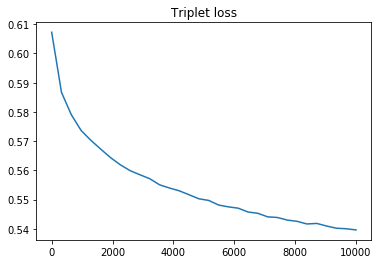

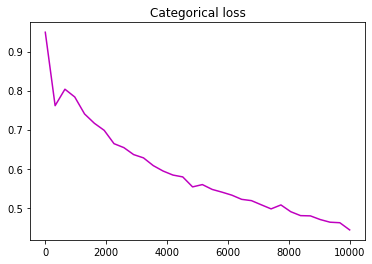

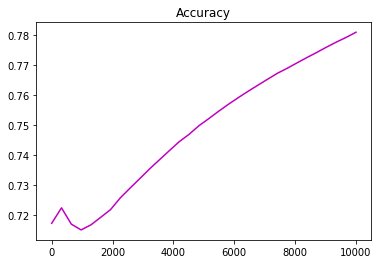

In [27]:
y_axis = [l[0] for l in loss_list]
x_axis = np.linspace(0, 10_000, len(y_axis)).round()
plt.plot(x_axis, y_axis)
plt.title("Triplet loss")
plt.show()

y_axis = [l[1] for l in loss_list]
x_axis = np.linspace(0, 10_000, len(y_axis)).round()
plt.plot(x_axis, y_axis, 'm')
plt.title("Categorical loss")
plt.show()

y_axis = [l[2] for l in loss_list]
x_axis = np.linspace(0, 10_000, len(y_axis)).round()
plt.plot(x_axis, y_axis, 'm')
plt.title("Accuracy")
plt.show()